In [69]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [28]:
df0 = pd.read_csv('/Users/ketansand/Downloads/Flight_Data/clean_data.csv', parse_dates=[1])

In [29]:
df0 = df0[df0['DEP_DELAY']>15]

In [42]:
df0 = df0[~df0["FL_DATE"].dt.year.isin([2020,2021,2023])] # excise pandemic
# delay_thresh=30.

# df0=df0.assign(DELAY_TF=pd.Series(df0['DEP_DELAY']>delay_thresh).values.astype(float)) # declare delay TRUE/FALSE 

df0['DELAY_range'] = df0['DEP_DELAY'].apply(lambda x: 0 if x <= 30 else x)
df0['DELAY_range'] = df0['DELAY_range'].apply(lambda x: 1 if (30 < x < 60) else x)
df0['DELAY_range'] = df0['DELAY_range'].apply(lambda x: 2 if x >= 60 else x)

df = pd.get_dummies(df0,columns=['OP_UNIQUE_CARRIER','ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID'], drop_first=True, dtype=float) # one-hot
X = df.drop(columns=['FL_DATE','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY','DEP_DELAY','DELAY_range'])
X = X.loc[:, ~X.columns.str.contains('^Unnamed')]
X = X.apply(pd.to_numeric)
X = X.assign(YEAR_FRAC_sin=pd.Series(np.sin(2.*np.pi*X['FRAC_YEAR']/1.0)).values)
X = X.assign(YEAR_FRAC_cos=pd.Series(np.cos(2.*np.pi*X['FRAC_YEAR']/1.0)).values)
X = X.assign(DAY_FRAC_sin=pd.Series(np.sin(2.*np.pi*X['FRAC_DAY']/1.0)).values)
X = X.assign(DAY_FRAC_cos=pd.Series(np.cos(2.*np.pi*X['FRAC_DAY']/1.0)).values)
X = X.drop(columns=['FRAC_DAY','FRAC_YEAR'])
y = df['DELAY_range']

In [43]:
X.head()

,AIR_TIME,OP_UNIQUE_CARRIER_AS,OP_UNIQUE_CARRIER_B6,OP_UNIQUE_CARRIER_DL,OP_UNIQUE_CARRIER_NK,OP_UNIQUE_CARRIER_OO,OP_UNIQUE_CARRIER_UA,OP_UNIQUE_CARRIER_WN,ORIGIN_AIRPORT_ID_10721,ORIGIN_AIRPORT_ID_11057,...,DEST_AIRPORT_ID_13487,DEST_AIRPORT_ID_13930,DEST_AIRPORT_ID_14107,DEST_AIRPORT_ID_14747,DEST_AIRPORT_ID_14771,DEST_AIRPORT_ID_14869,YEAR_FRAC_sin,YEAR_FRAC_cos,DAY_FRAC_sin,DAY_FRAC_cos
7,114.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.011218,0.999937,-0.821647,-0.569997
19,342.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.010753,0.999942,-0.713250,-0.700909
20,140.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.004089,0.999992,0.997250,0.074108
41,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.005591,0.999984,0.889017,-0.457874
45,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.010801,0.999942,-0.725374,-0.688355


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True,random_state=41,test_size=.2,stratify=y)

In [46]:
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
gc.collect()

107

In [48]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Fit the model to the training data
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [49]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

Accuracy: 0.40
Classification Report:
               precision    recall  f1-score   support

         0.0       0.40      0.61      0.48    151512
         1.0       0.33      0.01      0.02    126382
         2.0       0.41      0.53      0.46    145165

    accuracy                           0.40    423059
   macro avg       0.38      0.38      0.32    423059
weighted avg       0.38      0.40      0.34    423059



In [52]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [53]:
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

Accuracy: 0.57
Classification Report:
               precision    recall  f1-score   support

         0.0       0.59      0.65      0.62    151512
         1.0       0.51      0.44      0.47    126382
         2.0       0.59      0.60      0.60    145165

    accuracy                           0.57    423059
   macro avg       0.56      0.56      0.56    423059
weighted avg       0.57      0.57      0.57    423059



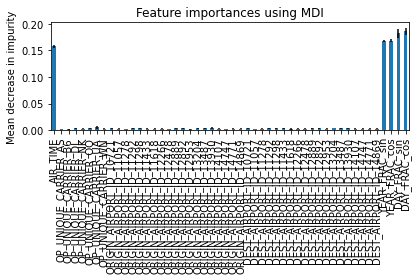

In [56]:

# feature importance based on impurity
importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)

feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

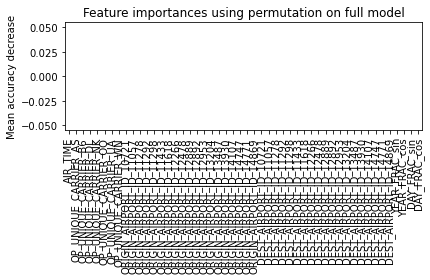

In [57]:
model_fi = permutation_importance(model, X, y, n_repeats=5, random_state=42)
forest_importances = pd.Series(model_fi.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=model_fi.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [60]:
###### Finding the best set of hyperparameters #########
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [70]:
###### Taking a lot of compute time ########
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
best_random = rf_random.best_estimator_

print(best_random)

y_pred = best_random.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

In [67]:
####### XG Boost ########
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(y)), random_state=42, 
                                   n_estimators = 100, max_depth=10)

# Fit the model to the training data
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [66]:
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

Accuracy: 0.43
Classification Report:
               precision    recall  f1-score   support

         0.0       0.43      0.62      0.50    151512
         1.0       0.41      0.06      0.10    126382
         2.0       0.44      0.56      0.49    145165

    accuracy                           0.43    423059
   macro avg       0.42      0.41      0.37    423059
weighted avg       0.42      0.43      0.38    423059

